# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import os
import sys
sys.path.append(os.path.abspath("/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna"))

In [70]:
from src.utils.data_loader import get_train_validation_input, get_train_validation_input_pandas
from src.utils.data_loader import load_predictor
from src.utils.data_loader import load_numeric_data

from src.utils.model_optimizer.evaluator import calculate_metrics
from src.utils.model_optimizer.optimizer import CellScaler

from src.utils.RNAseq_utils.RNAseq_utils import (LOPE_samples,
                                                 EOPE_samples,
                                                 control_samples,
                                                 assign_group)

In [71]:
file_paths = {
    "EOPE T1": "../../../../input/final_models/EOPE_T1/input_model_eope_ctr_t1_v6_36g_281024.csv",
    "EOPE T2": "../../../../input/final_models/EOPE_T2/input_model_eope_ctr_t2_v6_87g_281024.csv",
    "LOPE T1": "../../../../input/final_models/LOPE_T1/input_model_lope_ctr_t1_v6_19g_281024.csv",
    "LOPE T2": "../../../../input/final_models/LOPE_T2/input_model_lope_ctr_t2_v6_94g_281024.csv"
}

file_paths_all_genes = {
    "EOPE T1": "../../../../input/final_models/EOPE_T1/limma_counts_normal_eope_ctr_t1_not_hb.csv",
    "EOPE T2": "../../../../input/final_models/EOPE_T2/limma_counts_normal_eope_ctr_t2_not_hb.csv",
    "LOPE T1": "../../../../input/final_models/LOPE_T1/limma_counts_normal_lope_ctr_t1_not_hb.csv",
    "LOPE T2": "../../../../input/final_models/LOPE_T2/limma_counts_normal_lope_ctr_t2_not_hb.csv"
}

model_paths = {
    "EOPE T1": "../../../../input/final_models/EOPE_T1/eope_t1_TabPFNClassifier_optimal_281024.sav",
    "EOPE T2": "../../../../input/final_models/EOPE_T2/eope_t2_svm_optimal_281024.sav",
    "LOPE T1": "../../../../input/final_models/LOPE_T1/lope_t1_svm_optimal_281024.sav",
    "LOPE T2": "../../../../input/final_models/LOPE_T2/lope_t2_TabPFNClassifier_optimal_281024.sav"
}

# Define the thresholds for each type of PE
thresholds = {
    "EOPE T1": 0.601,
    "EOPE T2": 0.288,
    "LOPE T1": 0.264,
    "LOPE T2": 0.479
}

# Code

In [72]:
scaler = CellScaler()

results = []

for train_title, train_file_path in file_paths.items():
    print(f"--------------- Taking {train_title} model and genes to testing -----------------")
    # Load training data
    X_train, _, _, _ = get_train_validation_input_pandas(train_file_path)

    # get the genes, model and threshold
    selected_genes = list(X_train.columns)  
    optimal_threshold = thresholds[train_title]
    model = load_predictor(model_paths[train_title])
    
    for test_title, test_file_path in file_paths.items():
        # if train_title == test_title:
        #     continue

        print(f"Testing with {test_title} data")
        
        # Load the entire dataset for testing (not just validation)
        all_genes_data = pd.read_csv(file_paths_all_genes[test_title], index_col=0).T
        
        # scaling 0-1
        all_genes_data_scaled = pd.DataFrame(
            scaler.fit_transform(all_genes_data),
            columns=all_genes_data.columns,
            index=all_genes_data.index
        )

        # add labels PE or Control to all genes matrix
        all_genes_data_scaled["Sample Base"] = all_genes_data_scaled.index
        all_genes_data_scaled = assign_group(all_genes_data_scaled)

        # Ensure all required genes are present in the DataFrame
        for gene in selected_genes:
            if gene not in all_genes_data_scaled.columns:
                print(f"Gene {gene} not found in {test_title} data. Adding it with 0 values.")
                all_genes_data_scaled[gene] = 0

        # Predict probabilities using the trained model without NaN
        y_proba = model.predict_proba(all_genes_data_scaled[selected_genes].fillna(0))[:, 1]
        
        # tranform labels from PE Control to 1, 0
        y_true = [0 if x == "Control" else 1 for x in all_genes_data_scaled.Group.values]

        # Calculate metrics
        metrics = calculate_metrics(y_true, y_proba, optimal_threshold)
        
        # Append results
        results.append({
            "Model and genes": train_title,
            "Data validation": test_title,
            "F1_Score": metrics["F1_Score"],
            "AUC": metrics["AUC"]
        })

    print("\n")

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
results_df

--------------- Taking EOPE T1 model and genes to testing -----------------
Testing with EOPE T1 data


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Testing with EOPE T2 data


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Testing with LOPE T1 data
Gene MRPL38 not found in LOPE T1 data. Adding it with 0 values.
Testing with LOPE T2 data


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-package



--------------- Taking EOPE T2 model and genes to testing -----------------
Testing with EOPE T1 data
Gene MT-TG not found in EOPE T1 data. Adding it with 0 values.
Testing with EOPE T2 data


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Testing with LOPE T1 data


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Testing with LOPE T2 data


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(




--------------- Taking LOPE T1 model and genes to testing -----------------
Testing with EOPE T1 data
Gene ENSG00000229721 not found in EOPE T1 data. Adding it with 0 values.
Gene ENSG00000216809 not found in EOPE T1 data. Adding it with 0 values.
Testing with EOPE T2 data


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Testing with LOPE T1 data


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Testing with LOPE T2 data


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(




--------------- Taking LOPE T2 model and genes to testing -----------------
Testing with EOPE T1 data
Gene CFAP20DC-AS1 not found in EOPE T1 data. Adding it with 0 values.
Gene ENSG00000287552 not found in EOPE T1 data. Adding it with 0 values.
Gene CUL4AP1 not found in EOPE T1 data. Adding it with 0 values.
Gene ENSG00000200235 not found in EOPE T1 data. Adding it with 0 values.
Gene ENSG00000287825 not found in EOPE T1 data. Adding it with 0 values.
Gene ATP5F1AP10 not found in EOPE T1 data. Adding it with 0 values.
Gene ENSG00000285974 not found in EOPE T1 data. Adding it with 0 values.
Gene ENSG00000266489 not found in EOPE T1 data. Adding it with 0 values.
Gene TBL1Y not found in EOPE T1 data. Adding it with 0 values.


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Testing with EOPE T2 data
Gene C2CD4D not found in EOPE T2 data. Adding it with 0 values.
Gene CUL4AP1 not found in EOPE T2 data. Adding it with 0 values.
Gene ENSG00000287825 not found in EOPE T2 data. Adding it with 0 values.
Gene SLC29A4P2 not found in EOPE T2 data. Adding it with 0 values.
Gene HIGD1AP6 not found in EOPE T2 data. Adding it with 0 values.
Gene IGHV1-69-2 not found in EOPE T2 data. Adding it with 0 values.
Gene ENSG00000285974 not found in EOPE T2 data. Adding it with 0 values.


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Testing with LOPE T1 data
Gene DPP10-AS1 not found in LOPE T1 data. Adding it with 0 values.
Gene CFAP20DC-AS1 not found in LOPE T1 data. Adding it with 0 values.
Gene ENSG00000287552 not found in LOPE T1 data. Adding it with 0 values.
Gene CUL4AP1 not found in LOPE T1 data. Adding it with 0 values.
Gene ENSG00000200235 not found in LOPE T1 data. Adding it with 0 values.
Gene ENSG00000287825 not found in LOPE T1 data. Adding it with 0 values.
Gene ENSG00000285974 not found in LOPE T1 data. Adding it with 0 values.
Gene ENSG00000266489 not found in LOPE T1 data. Adding it with 0 values.


/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Testing with LOPE T2 data




/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna/.venv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


,Model and genes,Data validation,F1_Score,AUC
0,EOPE T1,EOPE T1,93,94
1,EOPE T1,EOPE T2,42,57
2,EOPE T1,LOPE T1,42,63
3,EOPE T1,LOPE T2,52,63
4,EOPE T2,EOPE T1,49,52
5,EOPE T2,EOPE T2,78,83
6,EOPE T2,LOPE T1,41,45
7,EOPE T2,LOPE T2,35,57
8,LOPE T1,EOPE T1,39,59
9,LOPE T1,EOPE T2,41,45


/tmp/ipykernel_187458/4245714641.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  f1_pivot = results_df.pivot("Model and genes", "Data validation", "F1_Score")
/tmp/ipykernel_187458/4245714641.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  auc_pivot = results_df.pivot("Model and genes", "Data validation", "AUC")


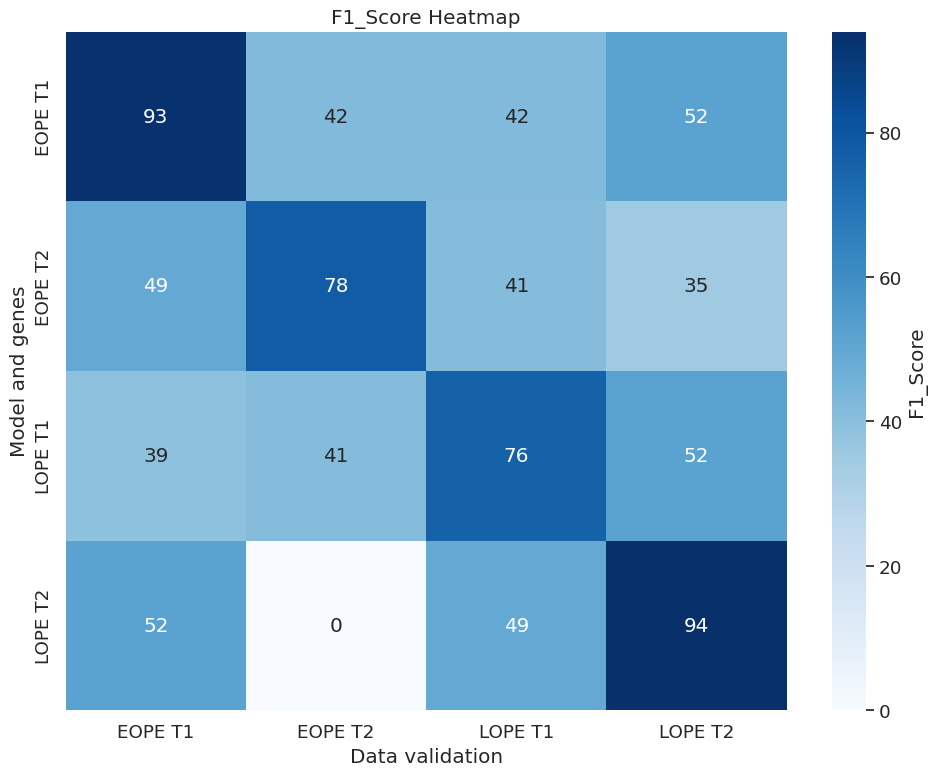

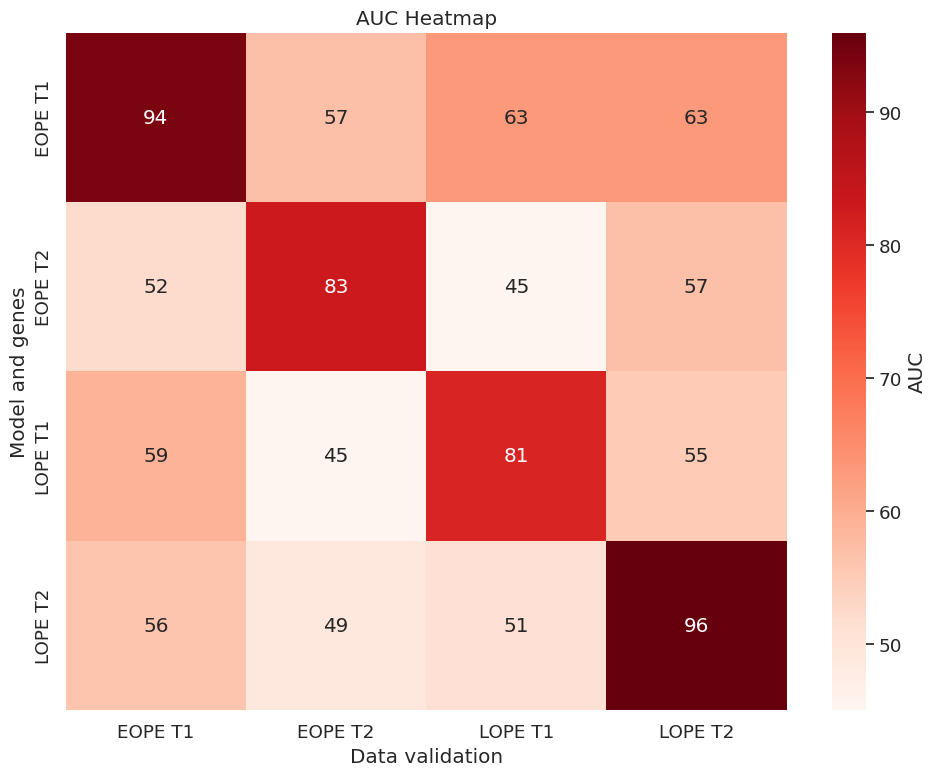

In [ ]:
# Crear una tabla pivotada para F1_Score
f1_pivot = results_df.pivot("Model and genes", "Data validation", "F1_Score")

# Crear una tabla pivotada para AUC
auc_pivot = results_df.pivot("Model and genes", "Data validation", "AUC")

# Configuración del estilo del gráfico
sns.set(style="whitegrid", font_scale=1.2)

# Graficar Heatmap para F1_Score
plt.figure(figsize=(10, 8))
sns.heatmap(f1_pivot, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'F1_Score'})
plt.title("F1_Score Heatmap")
plt.ylabel("Model and genes")
plt.xlabel("Data validation")
plt.tight_layout()
plt.show()

# Graficar Heatmap para AUC
plt.figure(figsize=(10, 8))
sns.heatmap(auc_pivot, annot=True, fmt=".0f", cmap="Reds", cbar_kws={'label': 'AUC'})
plt.title("AUC Heatmap")
plt.ylabel("Model and genes")
plt.xlabel("Data validation")
plt.tight_layout()
plt.show()
